# Evaluate strategies over multiple endpoints using boxplots

This notebook illustrates, how the predictions could be evaluated using boxplots.

For each endpoints, ACP's are trained both 'with and without normaliser model' and 'with and without updating the calibration set'. In this example, the calibration set is even updated twice. 

For comparison over all endpoints, the rmsd to the diagonal line in the calibration plot (significance level) is calculated. Here, the rmsd over all compounds is calculated, alternatively, we could also calculate it class-wise.

In [1]:
import pandas as pd
import numpy as np
import sys
import math
import tarfile

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [5]:
# # Define path to import script(s) from
# scripts_path = "../scripts/"
# sys.path.append(scripts_path)

In [6]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)

### Define paths and parameters

In [7]:
data_path = "../data/chembl_chembio_descriptors.tar.bz2"
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

In [8]:
endpoint_dict = {
    "CHEMBL279": ["VEGFR 2", "Vascular endothelial growth factor receptor 2"],
    "CHEMBL220": ["Acetylcholinesterase"],
    "CHEMBL4078": ["Acetylcholinesterase"],
    "CHEMBL5763": ["Cholinesterase"],
    "CHEMBL203": ["EGFR erbB1", "Epidermal growth factor receptor erbB1"],
    "CHEMBL206": ["Estrogen receptor alpha"],
    "CHEMBL222": ["Norepinephrine transporter"],
    "CHEMBL228": ["Serotonin transporter"],
    "CHEMBL230": ["Cyclooxygenase-2"],
    "CHEMBL340": ["Cytochrome P450 3A4"],
    "CHEMBL240": ["HERG"],
    "CHEMBL2039": ["Monoamine oxidase B"],
}

endpoints = list(endpoint_dict.keys())
print(endpoints)

['CHEMBL279', 'CHEMBL220', 'CHEMBL4078', 'CHEMBL5763', 'CHEMBL203', 'CHEMBL206', 'CHEMBL222', 'CHEMBL228', 'CHEMBL230', 'CHEMBL340', 'CHEMBL240', 'CHEMBL2039']


In [9]:
ntrees = 50
n_folds_acp = 3 # 20

### Define functions

In [10]:
def load_data_per_endpoint(data_dict, endpoint):
    data = data_dict[endpoint]
    data.dropna(subset=["year"], inplace=True)
    y = data[f"{endpoint}_bioactivity"].values
    columns = [col for col in data.columns if col.startswith('p') or col.startswith('byte')]
    X = data[columns].values
    years = data["year"].values
    return X, y, years

In [11]:
def split_data_per_endpoint(X, y, years, splits_df):
    thresholds = splits_df["train_thresh"][endpoint], splits_df["update1_thresh"][endpoint], splits_df["update2_thresh"][endpoint]
    
    mask_train = years <= thresholds[0]
    mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
    mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
    mask_holdout = years > thresholds[2]

    X_train, y_train = X[mask_train], y[mask_train]
    X_update1, y_update1 = X[mask_update1], y[mask_update1]
    X_update2, y_update2 = X[mask_update2], y[mask_update2]
    X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]
    
    return X_train, X_update1, X_update2, X_holdout, y_train, y_update1, y_update2, y_holdout

In [12]:
def prepare_rf_acp():
    clf = RandomForestClassifier(n_estimators=ntrees)
    error_function = InverseProbabilityErrFunc()
    nc = NcFactory.create_nc(clf, err_func=error_function, normalizer_model=None)
    icp = InductiveConformalPredictor(nc_function=nc, condition=(lambda instance: instance[1]), 
                                      smoothing=False)
    ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)
    acp = ContinuousCalibrationAggregatedConformalPredictor(
        predictor=icp, sampler=ratio_sampler, aggregation_func=np.median)
    return acp

In [13]:
def calculate_deviation_square(error, sl):
    return (error-sl)**2

In [14]:
def calculate_rmsd_from_df(eval_df, cl=None):
    if cl:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row[f"error_rate_{cl} mean"],   row["significance_level"]), axis=1)
    else:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row["error_rate mean"], row["significance_level"]), axis=1)
    rmsd = np.round(math.sqrt(np.mean(eval_df["square"])), 3)
    return rmsd

### Load data

#### Load datasets containing the chembio descriptors, labels and publication year

In [15]:
# Due to the size of the datasets containing the chembio descriptors, 
# they were uploaded to GitHub as tar.bz2 files and need to be unpacked first
tar = tarfile.open(data_path)

In [16]:
# The data is collected in the `files` dict, containing as keys the ChEMBL endpoint name and as value the dataframe
files = {}
for i, name in zip(tar, tar.getnames()):
    file = tar.extractfile(i)
    if file:  # Extraction also yields an empty folder (?) which will be ignored
        n = name.split("/")[1].split('_')[0]  # Get ChEMBL endpoint name from filename     
        df = pd.read_csv(file)  # Read df
        files[n] = df  # Store in dict

#### Load dataframe defining time-split thresholds per endpoint

In [17]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


### Run experiment (train different acps, calibrate, and predict) for all endpoints

In [18]:
evaluation_dfs = {"cv_original": [], 'original': [], 
                  'update1': [], 'update2': []}
for endpoint in endpoints:
    print(endpoint)
    # Prepare data
    X, y, years = load_data_per_endpoint(files, endpoint)
    X_train, X_update1, X_update2, X_holdout,\
    y_train, y_update1, y_update2, y_holdout = split_data_per_endpoint(
        X, y, years, splits_df
    )
    print(y_train.sum(), y_update1.sum(), y_update2.sum(), y_holdout.sum())
    
    # Define ACP and crossvalidator
    acp = prepare_rf_acp()
    cross_validator = CrossValidator(predictor=acp, cv_splitter=CrossValidationSampler())
    # Crossvalidate using 'original' calibration set
    cross_validator.cross_validate(
        X_train=X_train, y_train=y_train, X_score=X_holdout, y_score=y_holdout,
        steps=10, endpoint=endpoint
    )
    # Update calibration set within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update1, y_update=y_update1, X_score=X_holdout, y_score=y_holdout, 
        steps=10, endpoint=endpoint
    )
    # Update calibration set again within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update2, y_update=y_update2, X_score=X_holdout, y_score=y_holdout, 
        steps=10, endpoint=endpoint
    )
    # Store dataframes with evaluation values
    # fixme: We could even save the calibration plots within this loop
    
    evaluation_dfs["original"].append(cross_validator.averaged_evaluation_df_pred_score)
    evaluation_dfs["cv_original"].append(cross_validator.averaged_evaluation_df_cv)
    evaluation_dfs["update1"].append(cross_validator.averaged_evaluation_df_cal_update_1)
    evaluation_dfs["update2"].append(cross_validator.averaged_evaluation_df_cal_update_2)
    

CHEMBL279
649 307 137 299
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMBL220
840 248 138 113
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMBL4078
1008 275 202 270
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMBL5763
600 75 95 114
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMBL203
433 213 291 167
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMBL206
325 63 97 105
final n:  1
final n:  1
final n:  1
final n:  1
final n:  1
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
n 1
final n:  2
CHEMB

### Calculate rmsd's for all endpoints over all strategies

In [19]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)
rmsds

{'cv_original': [0.031,
  0.021,
  0.021,
  0.044,
  0.049,
  0.058,
  0.032,
  0.045,
  0.021,
  0.021,
  0.024,
  0.024],
 'original': [0.223,
  0.294,
  0.218,
  0.22,
  0.244,
  0.272,
  0.122,
  0.284,
  0.223,
  0.163,
  0.115,
  0.077],
 'update1': [0.019,
  0.112,
  0.028,
  0.065,
  0.043,
  0.174,
  0.05,
  0.025,
  0.048,
  0.091,
  0.062,
  0.072],
 'update2': [0.07,
  0.029,
  0.046,
  0.079,
  0.02,
  0.05,
  0.131,
  0.084,
  0.056,
  0.193,
  0.067,
  0.041]}

### Plot boxplot

In [20]:
strategies = ["cv_original", "original", "update1", "update2"]

Text(0.5, 1.0, 'rmsd over all endpoints')

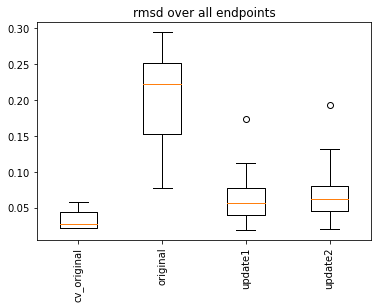

In [21]:
plt.boxplot([rmsds[k] for k in strategies], labels=strategies)
plt.xticks(rotation='vertical')
plt.title("rmsd over all endpoints")